In [4]:
import numpy as np
import pandas as pd
import re
import altair as alt
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

pd.options.display.max_columns = None

random_state = 42

In [5]:
#read in data
#fp year and fp day are unnecessary for clustering
df = pd.read_csv("../assets/ACE Mission Cleaned.csv").iloc[:, 2:]
df.head()

,proton_density,proton_temp,He4toprotons,proton_speed
0,16.655,9529.1,0.0127,323.90
1,20.601,8757.7,0.0141,322.89
2,18.679,9559.4,0.0087,324.61
3,18.481,8965.9,0.0051,322.68
4,28.315,8329.0,0.0061,321.84


In [6]:
#scale the data using standard scaler
scaled_df = StandardScaler().fit_transform(df)

In [7]:
#what are the optimal number of clusters? 
#find the calinski and davies scores of different numbers of kmeans clusters
#optimal cluster numbers will have a high Calinski and a low Davies score 

cluster = []
calinski = []
davies = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=random_state).fit(scaled_df)
    labels = kmeans.labels_
    
    cluster.append(k)
    calinski.append(metrics.calinski_harabasz_score(scaled_df, labels))
    davies.append(davies_bouldin_score(scaled_df, labels))

In [8]:
cluster_scores = pd.DataFrame({'num_cluster': cluster, 'calinski': calinski, 'davies': davies})
cluster_scores

,num_cluster,calinski,davies
0,2,57797.596012,1.106740
1,3,49242.224949,1.104847
2,4,50798.331002,1.054070
3,5,47491.660015,1.094343
4,6,46585.772638,1.124053
5,7,43948.491179,1.137292
6,8,40886.714765,1.191542
7,9,41326.574760,1.162049


Text(0.5, 0.98, 'Scoring to Determine Optimal Number of Clusters \n Looking for clusters that have a low Davies-Bouldin score but a high Calinski-Harabasz score')

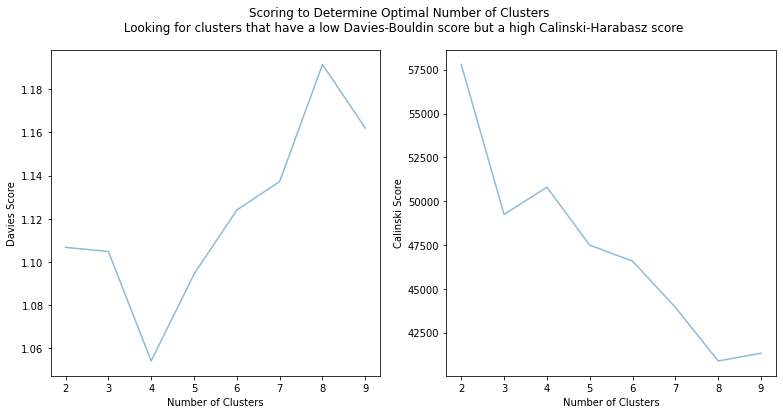

In [9]:

#visualize the Calinski and Davies scores
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(13, 6))

ax1.plot(cluster_scores['num_cluster'], cluster_scores['davies'], alpha=0.5)
ax1.set_ylabel('Davies Score')
ax1.set_xlabel('Number of Clusters')

ax2.plot(cluster_scores['num_cluster'], cluster_scores['calinski'], alpha=0.5)
ax2.set_ylabel('Calinski Score')
ax2.set_xlabel('Number of Clusters')

fig.suptitle('Scoring to Determine Optimal Number of Clusters \n Looking for clusters that have a low Davies-Bouldin score but a high Calinski-Harabasz score')
     

In [10]:
#an elbow plot can also be used to look for the optimal number of clusters
sum_of_squared_distances = []
K = range(2,10)
for k in K:
    k_means = KMeans(n_clusters=k,init = 'k-means++',n_init = 1)
    model = k_means.fit(scaled_df)
    sum_of_squared_distances.append(k_means.inertia_)

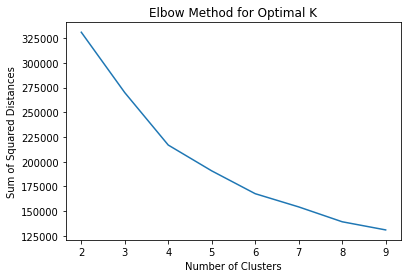

In [11]:
plt.plot(K, sum_of_squared_distances)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal K')
plt.show()

In [12]:
optimal_k = 4 #appears to be optimal after comparing the Davies scores, Calinski scores, and the elbow plot

#build a kmeans model using the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=100, n_init=1, random_state=random_state).fit(scaled_df)

In [13]:
#https://towardsdatascience.com/clustering-with-k-means-1e07a8bfb7ca
#function that creates a dataframe with a column for cluster number
centers = kmeans.cluster_centers_
def pd_centers(cols_of_interest, centers):
    random_state=random_state
    colNames = cols_of_interest.copy()
    colNames.append('prediction')
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P
P = pd_centers(['Proton Density', 'Proton Temp', 'He4toproton', 'Speed'], centers)
P #these are the transformed values

,Proton Density,Proton Temp,He4toproton,Speed,prediction
0,-0.128559,-0.432876,-0.379012,-0.495972,0
1,2.564002,-0.452186,-0.166791,-0.701001,1
2,-0.423408,1.271149,-0.174936,1.323906,2
3,-0.115371,-0.493274,1.554561,-0.263480,3


In [14]:
Pcenters = pd.melt(P, id_vars = ['prediction'], var_name = 'var', value_name = 'val')
Pcenters['prediction'] = Pcenters['prediction'].astype(str)
fig = px.scatter(Pcenters, x='val', y='prediction', color='var', 
            labels=dict(val='Value', var='Features', prediction='Predicted Cluster'),
                title='K-Means Clustering of Solar Winds')
fig.update_layout(plot_bgcolor='white', autosize=False, width=900, height=500, title={'x':0.5, 'xanchor':'center', 'y':0.875})
fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    zerolinecolor='black', zerolinewidth=0.25,
    gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    zerolinecolor='black',
    gridcolor='lightgrey'
)
fig.update_traces(marker=dict(size=12))
     